In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from cmocean import cm
from xhistogram.xarray import histogram

from matplotlib import pyplot as plt
%matplotlib inline
from mitequinox.utils import *

In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(14*3)

In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.0.254:47630 Dashboard: http://10.148.0.254:8787/status,Cluster Workers: 35 Cores: 35 Memory: 558.95 GiB


_____________
# 2. read w'b' (spatially averaged)

In [5]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/VBF/'
wb_prime_filter = xr.open_zarr(out_dir_zarr+'wb_prime_1day_filter.zarr')
wb_prime_filter

<xarray.Dataset>
Dimensions:          (depth: 52, time: 9415)
Coordinates:
  * depth            (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time             (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
Data variables:
    wb_prime_filter  (time, depth) float32 dask.array<chunksize=(9415, 1), meta=np.ndarray>

In [7]:
# Coarse-grained PI (spatial average and cumulative integral)
out_dir_store = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/temporary/cg_butter/'
PI_cg = xr.open_zarr(out_dir_store+'PI_cg_butter_5d_all.zarr')
PI_cg_smean = PI_cg.PI_cg_smean
PI_cg_smean

<xarray.DataArray 'PI_cg_smean' (depth: 52, time: 9415)>
dask.array<xarray-PI_cg_smean, shape=(52, 9415), dtype=float32, chunksize=(1, 9415), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2

In [9]:
ds = xr.merge([PI_cg_smean,wb_prime_filter])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))
ds = ds.assign_coords(time=time_day) 
#ds.persist()
ds

<xarray.Dataset>
Dimensions:          (depth: 52, time: 9415)
Coordinates:
  * depth            (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time             (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg_smean      (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>
    wb_prime_filter  (time, depth) float32 dask.array<chunksize=(9415, 1), meta=np.ndarray>

In [10]:
winter = ds.isel(depth=slice(16,39)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00'))
winter

<xarray.Dataset>
Dimensions:          (depth: 23, time: 2185)
Coordinates:
  * depth            (depth) float64 52.69 60.28 68.69 ... 410.4 441.3 473.3
  * time             (time) datetime64[ns] 2011-12-01 ... 2012-03-01
Data variables:
    PI_cg_smean      (depth, time) float32 dask.array<chunksize=(1, 2185), meta=np.ndarray>
    wb_prime_filter  (time, depth) float32 dask.array<chunksize=(2185, 1), meta=np.ndarray>

In [13]:
# save
file_out = out_dir_zarr+'/wb_PI_winter_1016.nc'
%time winter.to_netcdf(file_out, mode='w')   

CPU times: user 252 ms, sys: 36 ms, total: 288 ms
Wall time: 2.8 s


_____________
# 3. read w'b' (4D)

In [6]:
out_dir_store = '/home1/scratch/xyu/Energtics/'
D = [xr.open_zarr(out_dir_store+'wb_10day_prime_filter_d%02d.zarr'%(depth)) for depth in range(52)]
wb_time_prime = xr.concat(D, dim='depth')
wb_time_prime = wb_time_prime.wb_time_prime_filter
wb_time_prime

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [7]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/'
D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_5d = xr.concat(D, dim='depth')

def iters_to_date(iters, delta_t=3600.):
    t0 = datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))
PI_cg_5d = PI_cg_5d.assign_coords(time=time_day) 
PI_cg_5d = PI_cg_5d.assign_coords(depth=wb_time_prime.depth) 

print(PI_cg_5d)

<xarray.Dataset>
Dimensions:       (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
Data variables:
    PI_cg_single  (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>


In [8]:
# Coarse-grained PI (spatial average and cumulative integral)

ds = xr.merge([PI_cg_5d,wb_time_prime])
ds

,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,64.89 GiB,6.36 MiB
Shape,"(52, 9415, 201, 177)","(1, 9415, 1, 177)"
Count,31408 Tasks,10452 Chunks
Type,float32,numpy.ndarray


In [9]:
winter = ds.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(16,39)).sel(time=slice('2011-12-01T00:00:00','2012-03-01T00:00:00'))
winter.load()
print(winter)
print('\n data size: %.1f GB' %(winter.nbytes / 1e9))


 data size: 13.7 GB


In [11]:
x_bins = np.arange(0, 5e-6, 1e-8)
y_bins = np.arange(-5e-6,0, 1e-8)

hTS = histogram(winter.wb_time_prime_filter, 
                winter.PI_cg_single, 
                bins=[x_bins, y_bins],
                block_size=None)
hTS#.persist()

<xarray.DataArray 'histogram_wb_time_prime_filter_PI_cg_single' (wb_time_prime_filter_bin: 500, PI_cg_single_bin: 500)>
array([[        0,         0,         0, ...,  18737168,  43003922,
        245712206],
       [        0,         0,         0, ...,   8087258,  16395932,
         72311274],
       [        0,         0,         0, ...,   5208469,   9982410,
         39914764],
       ...,
       [        0,         0,         0, ...,         0,         0,
                0],
       [        0,         0,         0, ...,         0,         0,
                0],
       [        0,         0,         0, ...,         0,         0,
                0]])
Coordinates:
  * wb_time_prime_filter_bin  (wb_time_prime_filter_bin) float64 5e-09 ... 4....
  * PI_cg_single_bin          (PI_cg_single_bin) float64 -4.995e-06 ... -5e-09

(-4e-07, 0.0)

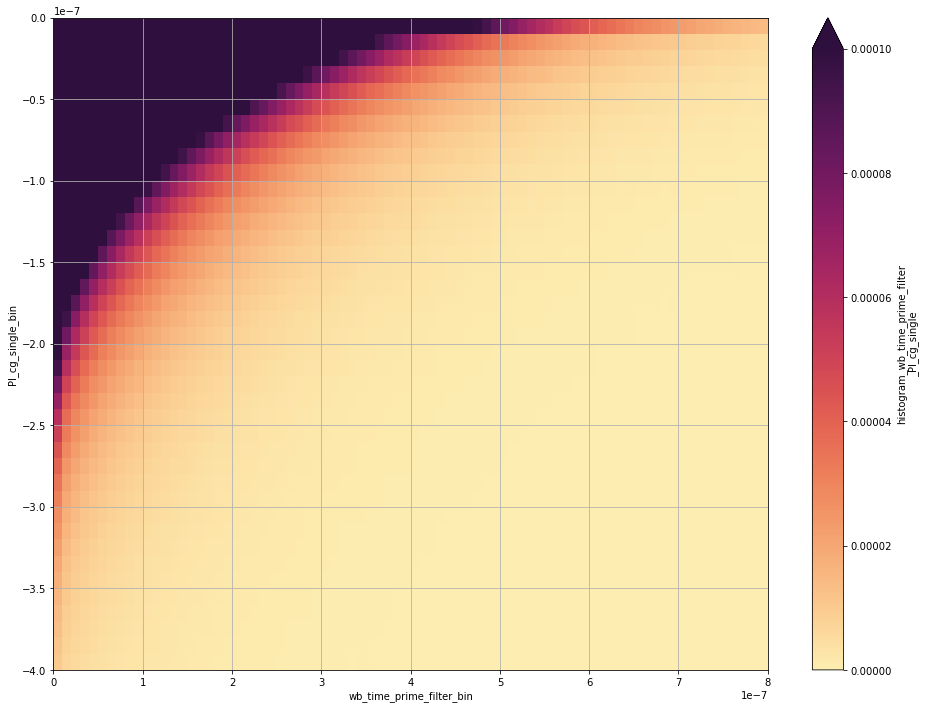

In [19]:
fig = plt.figure(figsize=(16,12))

ax = plt.subplot(111)
#np.log10(hTS).plot(x='wb_time_prime_filter_bin',y='PI_cg_single_bin',cmap=cm.matter,vmin=0,vmax=4)
cax = (hTS/hTS.sum()).plot(x='wb_time_prime_filter_bin',y='PI_cg_single_bin',cmap=cm.matter,vmin=0,vmax=0.0001) 
ax.grid()
ax.set_xlim([0,8e-7])
ax.set_ylim([-4e-7,0])

(-2e-06, 2e-06)

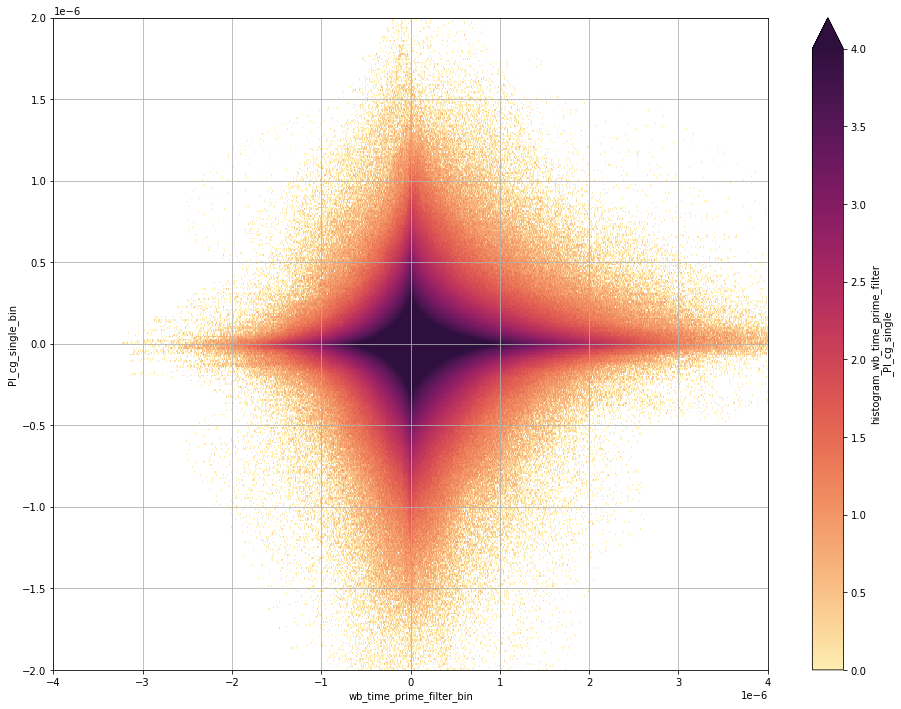

In [35]:
fig = plt.figure(figsize=(16,12))

ax = plt.subplot(111)
np.log10(hTS).plot(x='wb_time_prime_filter_bin',y='PI_cg_single_bin',cmap=cm.matter,vmin=0,vmax=4)
ax.grid()
ax.set_xlim([-4e-6,4e-6])
ax.set_ylim([-2e-6,2e-6])

In [20]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
